<a href="https://colab.research.google.com/github/antussa2016/Data_mining/blob/master/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import wordcloud as WordCloud

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report, accuracy_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
fake = pd.read_csv("/content/drive/MyDrive/Fake.csv")

In [ ]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [ ]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

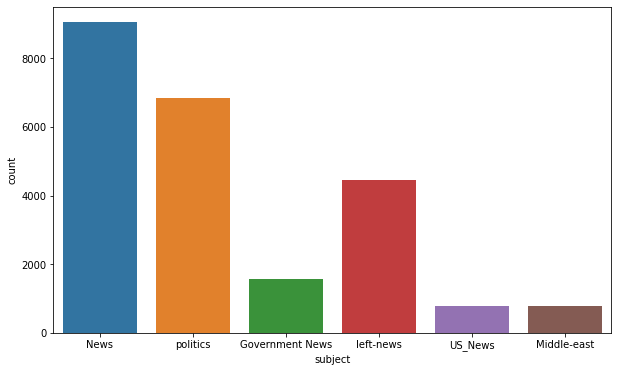

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='subject', data=fake)

# **Wordcloud** 

In [ ]:
text=' '.join(fake['text'].tolist())
type(text)

str

In [ ]:
' '.join(['i','am','antu'])

'i am antu'

In [ ]:
wordCloud = WordCloud.WordCloud(width=1920,height=1000).generate(text)


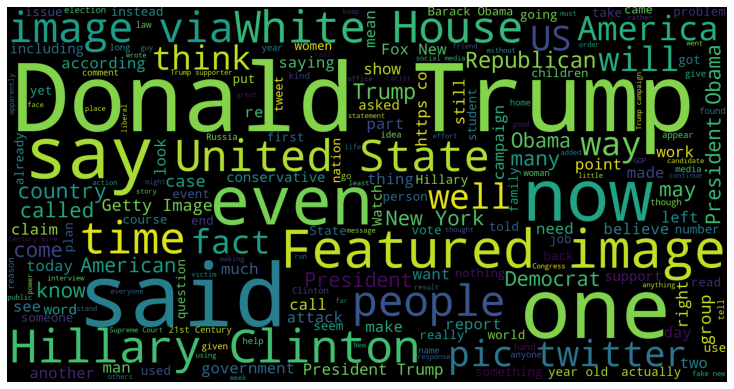

In [ ]:
fig=plt.figure(figsize=(10,6))
plt.imshow(wordCloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Explore Real news

In [ ]:
real = pd.read_csv("/content/drive/MyDrive/True.csv")
text=' '.join(real['text'].tolist())

In [ ]:
wordCloud = WordCloud.WordCloud(width=1920,height=1000).generate(text)

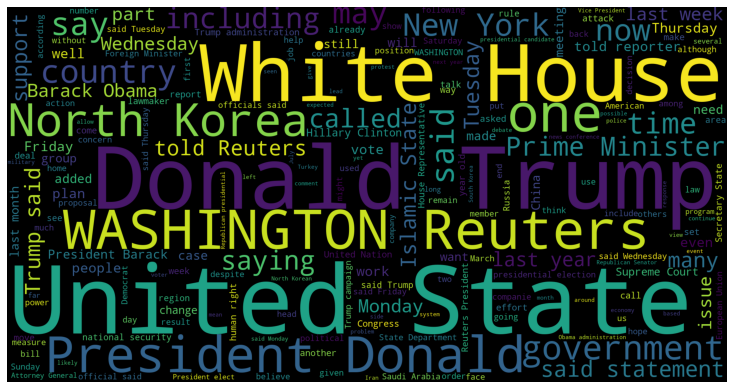

In [ ]:
fig=plt.figure(figsize=(10,6))
plt.imshow(wordCloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
real.sample(5)

,title,text,subject,date
7584,White House study: China trade deal worsens da...,WASHINGTON (Reuters) - The Obama administratio...,politicsNews,"November 3, 2016"
4586,White House says new information has emerged o...,WASHINGTON (Reuters) - The White House has inv...,politicsNews,"March 30, 2017"
415,Trump plans to meet oil industry reps on U.S. ...,(Reuters) - U.S. President Donald Trump has ag...,politicsNews,"December 1, 2017"
19138,British police arrest seventh man over bomb at...,LONDON (Reuters) - British police made a new a...,worldnews,"September 25, 2017"
19469,EU says wants clear Brexit commitments from Br...,ROME (Reuters) - The European Union wants Brit...,worldnews,"September 21, 2017"


In [ ]:
unknown_publishers = []
for index, row in enumerate(real.text.values):
  try:
    record = row.split('-', maxsplit=1)
    record[1]

    assert(len(record[0])<120)

  except:
    unknown_publishers.append(index)

In [ ]:
len(unknown_publishers)

222

In [ ]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [ ]:
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [ ]:
real= real.drop(8970,axis=0)

In [ ]:
publisher=[]
tmp_text=[]

for index, row in enumerate(real.text.values):
  if index in unknown_publishers:
    tmp_text.append(row)
    publisher.append('Unknown')
    continue
  else:
    record = row.split('-', maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())

In [ ]:
real['publisher']=publisher
real['text']=tmp_text

In [ ]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [ ]:
real.shape

(21416, 5)

In [ ]:
empty_fake_index=[index for index, text in enumerate(fake.text.tolist()) if str(text).strip()==""]

In [ ]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [ ]:
real['text']=real['title']+" "+real['text']
fake['text']=fake['title']+" "+fake['text']

In [ ]:
real['text']=real['text'].apply(lambda x: str(x).lower())
fake['text']=fake['text'].apply(lambda x: str(x).lower())


# Processing text

In [ ]:
real['class']=1
fake['class']=0

In [ ]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [ ]:
real = real[['text','class']]

In [ ]:
fake = fake[['text','class']]

In [ ]:
data = real.append(fake, ignore_index=True)

In [ ]:
data.sample(5)

,text,class
11092,clinton 'happy' to join extra debate if other ...,1
37788,new york times publishes trump tax return from...,0
20442,china court releases video of taiwanese activi...,1
32913,trump shocks supporters with surprise visit at...,0
44638,‘anti-russia’ escalation? plans for new us mar...,0


In [ ]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

     |████████████████████████████████| 12.0 MB 4.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-hkb2ncob
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-hkb2ncob
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=11754 sha256=afffde87290ebeada4bd789969416bf44552dede86fcf54b0cda62dcb88efa7a
  Stored in directory: /tmp/pip-ephem-wheel-cache-t7mjy5hz/wheels/0d/b3/29/bfe3deffda68980088d17b81331be6667e837ffb4a071bae82
Successfully built preprocess-kgptalkie
  Attempting uninstall: preprocess-kgptalkie
    Found existing installation: preprocess-kgptalkie 0.1.3
    Uninstalling preprocess-kgptalkie-0.1.3:
      Successfully uninstalled preprocess-kgptalkie-0.1.3


In [ ]:
import preprocess_kgptalkie as ps

In [ ]:
data['text']=data['text'].apply(lambda x:ps.remove_special_chars(x))

In [ ]:
data.head()

,text,class
0,as us budget fight looms republicans flip thei...,1
1,us military to accept transgender recruits on ...,1
2,senior us republican senator let mr mueller do...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge much more...,1


# Word2Vector

In [ ]:
import gensim

In [ ]:
y=data['class'].values

In [ ]:
X= [d.split() for d in data['text'].tolist()]

In [ ]:
type(X[0])

list

In [ ]:
print(X[0])

['as', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'script', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'us', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', '2018', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issues',

In [ ]:
DIM=100
w2v_model = gensim.models.Word2Vec(sentences=X, size=DIM, window=10, min_count=1)

In [ ]:
len(w2v_model.wv.vocab)

231872

In [ ]:
w2v_model.wv.most_similar('bangladesh')

[('rohingya', 0.8089929819107056),
 ('myanmar', 0.7435121536254883),
 ('rohingyas', 0.7179998159408569),
 ('bazar', 0.6812463402748108),
 ('dhaka', 0.6696608662605286),
 ('pyin', 0.6627515554428101),
 ('nauk', 0.6510978937149048),
 ('refugees', 0.6458768248558044),
 ('syrians', 0.638087809085846),
 ('camps', 0.6367876529693604)]

In [ ]:
tokenizer= Tokenizer()
tokenizer.fit_on_texts(X)

In [ ]:
X=tokenizer.texts_to_sequences(X)

In [ ]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'and': 5,
 'in': 6,
 'that': 7,
 'on': 8,
 'for': 9,
 's': 10,
 'is': 11,
 'he': 12,
 'said': 13,
 'trump': 14,
 'it': 15,
 'with': 16,
 'was': 17,
 'as': 18,
 'his': 19,
 'by': 20,
 'has': 21,
 'be': 22,
 'have': 23,
 'not': 24,
 'from': 25,
 'this': 26,
 'at': 27,
 'are': 28,
 'who': 29,
 'us': 30,
 'an': 31,
 'they': 32,
 'i': 33,
 'but': 34,
 'we': 35,
 'would': 36,
 'president': 37,
 'about': 38,
 'will': 39,
 'their': 40,
 'had': 41,
 'you': 42,
 't': 43,
 'been': 44,
 'were': 45,
 'people': 46,
 'more': 47,
 'or': 48,
 'after': 49,
 'which': 50,
 'she': 51,
 'her': 52,
 'one': 53,
 'if': 54,
 'its': 55,
 'out': 56,
 'all': 57,
 'what': 58,
 'state': 59,
 'when': 60,
 'new': 61,
 'also': 62,
 'up': 63,
 'there': 64,
 'over': 65,
 'no': 66,
 'house': 67,
 'donald': 68,
 'our': 69,
 'states': 70,
 'clinton': 71,
 'obama': 72,
 'government': 73,
 'can': 74,
 'just': 75,
 'him': 76,
 'so': 77,
 'than': 78,
 'republican': 79,
 'other': 80,
 'so

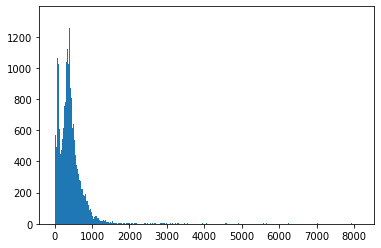

In [ ]:
plt.hist([len(x)for x in X], bins=700 )
plt.show()

In [ ]:
nos=np.array([len(x) for x in X])
len(nos[nos>1000])

1581

In [ ]:
maxlen=1000
X=pad_sequences(X, maxlen=maxlen)

In [ ]:
len(X[1])

1000

In [ ]:
vocab_size = len(tokenizer.word_index)+1
vocab=tokenizer.word_index

In [ ]:
def get_weight_matrix(model):
  weight_marix= np.zeros((vocab_size, DIM))

  for word, i in vocab.items():
    weight_marix[i]= model.wv[word]

  return weight_marix



In [ ]:
embedding_vectors=get_weight_matrix(w2v_model)

In [ ]:
embedding_vectors.shape

(231873, 100)

# Mechine learning Model

In [ ]:
model=Sequential()
model.add(Embedding(vocab_size,output_dim=DIM,weights=[embedding_vectors], input_length=maxlen,trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 100)         23187300  
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 23,304,677
Trainable params: 117,377
Non-trainable params: 23,187,300
_________________________________________________________________


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,y)

In [ ]:
model.fit(x_train,y_train,validation_split=0.3, epochs=6)

Epoch 1/6
737/737 [==============================] - 783s 1s/step - loss: 0.1432 - acc: 0.9479 - val_loss: 0.1139 - val_acc: 0.9628
Epoch 2/6
737/737 [==============================] - 774s 1s/step - loss: 0.0743 - acc: 0.9759 - val_loss: 0.0428 - val_acc: 0.9870
Epoch 3/6
737/737 [==============================] - 771s 1s/step - loss: 0.0293 - acc: 0.9910 - val_loss: 0.0286 - val_acc: 0.9905
Epoch 4/6
737/737 [==============================] - 772s 1s/step - loss: 0.0195 - acc: 0.9937 - val_loss: 0.0228 - val_acc: 0.9936
Epoch 5/6
737/737 [==============================] - 772s 1s/step - loss: 0.0370 - acc: 0.9874 - val_loss: 0.0344 - val_acc: 0.9893
Epoch 6/6
737/737 [==============================] - 773s 1s/step - loss: 0.0117 - acc: 0.9961 - val_loss: 0.0223 - val_acc: 0.9931


In [ ]:
y_pred=(model.predict(x_test) > 0.5).astype(int)

In [ ]:
accuracy_score(y_test,y_pred)

0.9924276169265034

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5874
           1       0.99      0.99      0.99      5351

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



# Real News testing

Fake news

In [152]:
x=['My name is antu']
x= tokenizer.texts_to_sequences(x)
x=pad_sequences(x, maxlen=maxlen)

In [153]:
(model.predict(x) > 0.5).astype(int)

array([[0]])

real news

In [154]:
x=['For example, certain patients deemed less likely to survive may not get a bed in the intensive care unit. Nurses may be asked to treat many more patients than is normally considered safe. Patients may have to be discharged from the hospital before they would normally go home, and some patients who would usually be admitted for hospital care might have to be denied']
x= tokenizer.texts_to_sequences(x)
x=pad_sequences(x, maxlen=maxlen)
(model.predict(x) >= 0.5).astype(int)

array([[0]])